In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 100 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
total_weeks = 100

stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params)
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2/demand_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2/supply_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        # lst3 = []
        # for row in simulation_this_week.exposed_prices:
        #     row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
        #     lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2/exposed_prices_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(simulation_this_week.exposed_prices, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [6]:
weekly_sim_log_df = pd.read_json("../data/100_weeks_a_r1.5_b_r-0.2/logfile_matched_trips_week_0_.log", lines=True)

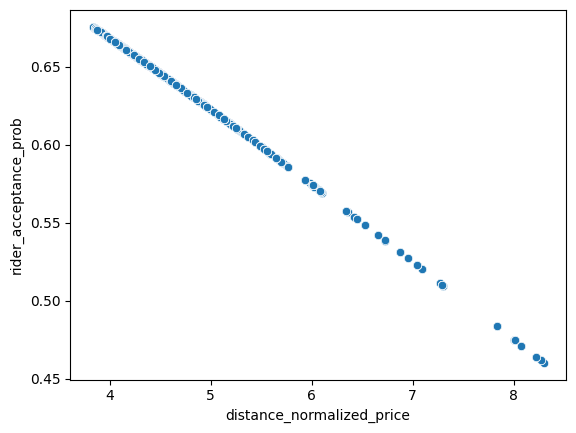

In [7]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [8]:
weekly_sim_log_df.shape

(1697, 12)

In [9]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

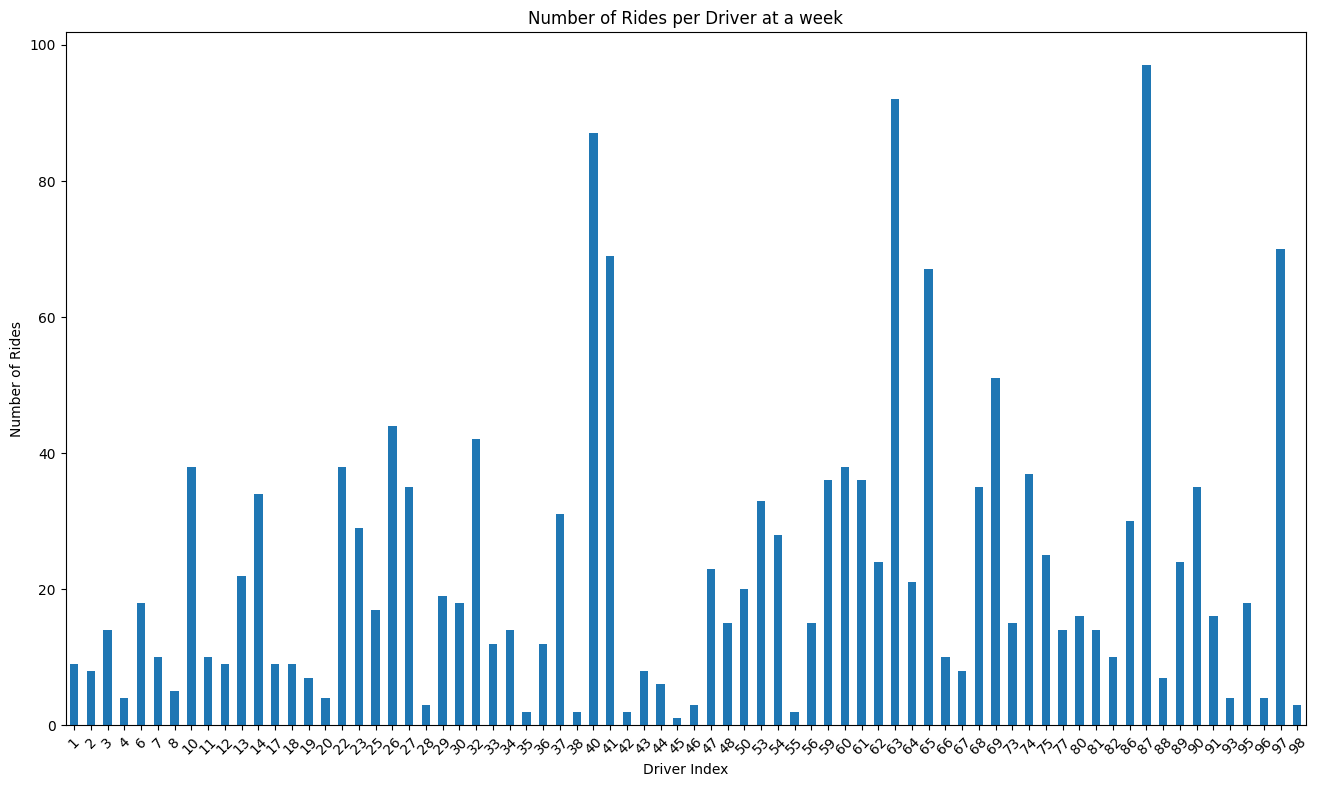

In [10]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 25.89 riders per week

In [11]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

22.93243243243243

In [12]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.621335769004125, 0.6394090748379493)

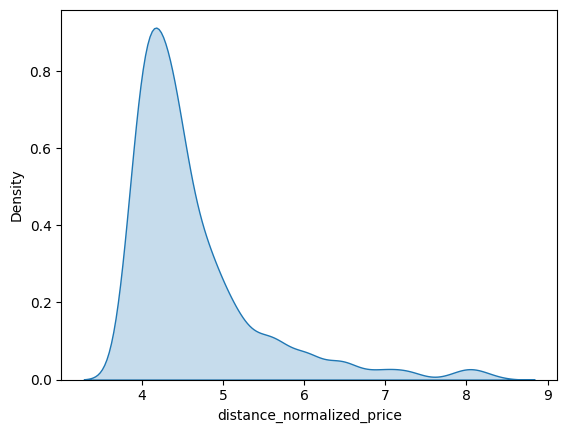

In [13]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

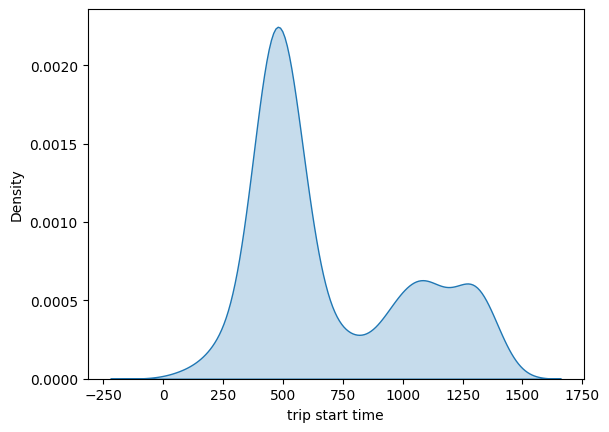

In [14]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

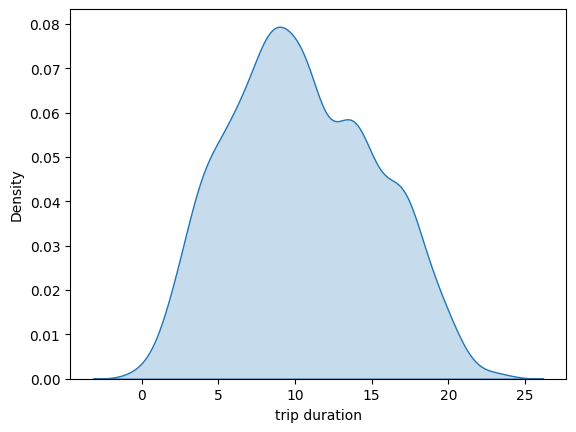

In [15]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

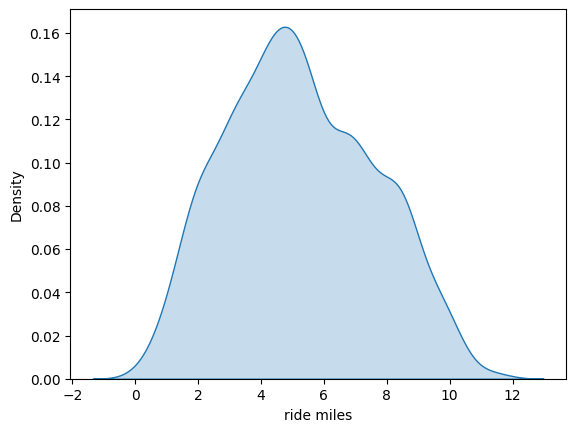

In [16]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

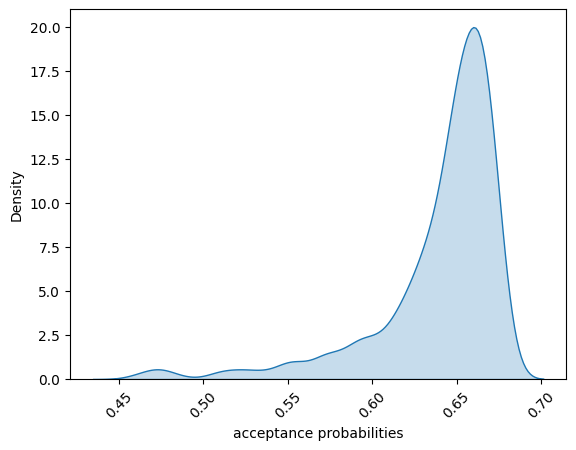

In [17]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

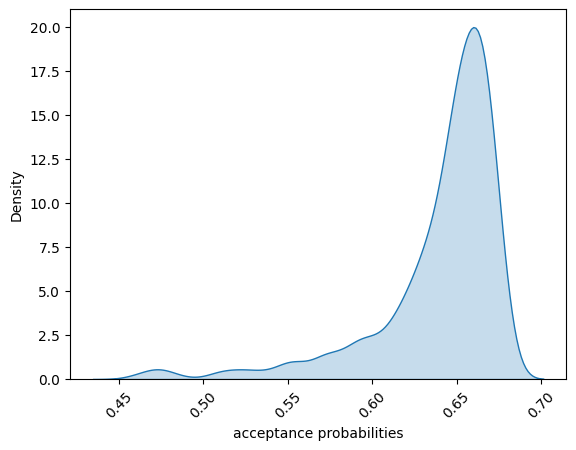

In [18]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [39]:
daily_avg_price_lst, daily_total_requests = [], []
for i in range(100):
    prices_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.2/exposed_prices_week_'+str(i)+'.json')
    requests_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.2/demand_week_'+str(i)+'.json')
    daily_avg_price_lst.append(prices_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [40]:
prices_df.head(2)

,price_of_ride,distance_normalized_price,trip_duration,rider_acceptance_prob,driver_acceptance_prob
0,16.7776,4.8334,7,0.6303,0.6303
1,23.8174,4.2343,11,0.6577,0.6577


In [41]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [42]:
long_term_rider_elasticity_df.head()

,daily_avg_price,daily_total_requests
0,22.438710,976
1,22.372956,1041
2,22.779001,921
3,22.678564,992
4,23.048053,949


In [43]:
long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [44]:
long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [45]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(22.584578573867162, 1001.47)

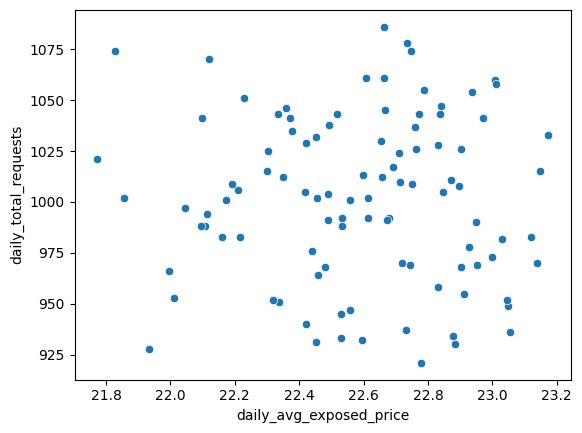

In [49]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.xlabel('daily_avg_exposed_price')
plt.show()

In [48]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-4.358548903747037,
 1099.9059901847177,
 -0.035141808906408736,
 0.7285108326950114,
 12.520925790288825)

### as below, the ride share company makes $7.07 per ride

In [ ]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(23.57, 45169.42080000001)

In [ ]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

7.07